# Práctica 4

Ana Gil Molina

### Ejercicio 1: Aprendizaje de Redes Bayesianas

Dado el conjunto de datos *sample_energy.csv* queremos llevar a cabo el aprendizaje de una red bayesiana que lo modele.

El conjunto de datos recoge el uso de energía eléctrica en edificios dedicados a educación a partir de ciertas características de estos:

- "EUI" - intensidad del uso de energía con valores de 1 a 5, desde 1 representando el valor muy bajo a 5
representando el valor muy alto
- "area" - de la escuela en $m^2$ (discretizado a los valores 1, 2, 3)
- "students" - número de estudiantes (discretizado a los valores 1, 2, 3)
- "floors" - número de plantas del edificio (1 ó 2)
- "event" - si hay o no eventos especiales en esa escuela

Resolver:

a) Usando la librería pgmpy de Python, realizar el aprendizaje de la red bayesiana (estructura y parámetros).

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import TreeSearch
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from IPython.display import Image

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Nodos en el modelo: ['EUI', 'area', 'floors', 'event', 'students'] 

Aristas en el modelo: [('EUI', 'area'), ('EUI', 'floors'), ('EUI', 'event'), ('EUI', 'students')] 



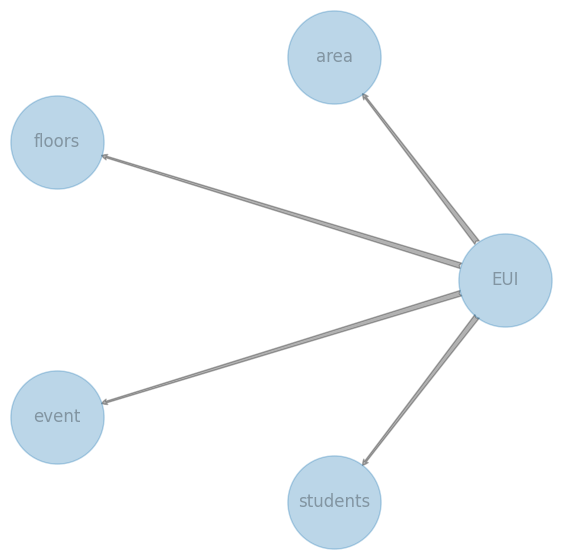

In [2]:
# Leer datos del fichero

datos = pd.read_csv("sample_energy.csv")

# Estimar la estructura del grafo que mejor se ajusta a los datos sin los parámetros

est = TreeSearch(datos, root_node=None)
model = est.estimate(estimator_type='chow-liu') # model es un grafo(DAG)

# Acceder a los atributos del modelo

nodes = model.nodes()
edges = model.edges()
print(f"Nodos en el modelo: {nodes} \n")
print(f"Aristas en el modelo: {edges} \n")

# Dibujar la estructura

tam = 4500

fig,ax1 = plt.subplots(figsize=(7,7))
nx.draw_circular(model, with_labels=True, ax = ax1, arrowsize=10, arrowstyle='fancy',alpha=0.3,node_size = tam)
plt.show()

In [3]:
# Una vez estimada la estructura, se aprenden los parámetros

model2 = BayesianNetwork(model) # model es un DAG y se pasa a BayesianNetwork

model2.fit(datos[:40000]) # por defecto es MaximumLikelihoodsEstimator
cpds = model2.get_cpds()

print(f"CPDs en el modelo: ")
for cpd in cpds:
    print(cpd)

# Guardar la red en un fichero bif

model2.save("eui_model.bif", filetype='bif')

CPDs en el modelo: 
+--------+----------+
| EUI(1) | 0.236    |
+--------+----------+
| EUI(2) | 0.487675 |
+--------+----------+
| EUI(3) | 0.2327   |
+--------+----------+
| EUI(4) | 0.0398   |
+--------+----------+
| EUI(5) | 0.003825 |
+--------+----------+
+---------+---------------------+-----+---------------------+
| EUI     | EUI(1)              | ... | EUI(5)              |
+---------+---------------------+-----+---------------------+
| area(1) | 0.6                 | ... | 0.17647058823529413 |
+---------+---------------------+-----+---------------------+
| area(2) | 0.2989406779661017  | ... | 0.24183006535947713 |
+---------+---------------------+-----+---------------------+
| area(3) | 0.10105932203389831 | ... | 0.5816993464052288  |
+---------+---------------------+-----+---------------------+
+-----------+----------------------+-----+---------------------+
| EUI       | EUI(1)               | ... | EUI(5)              |
+-----------+----------------------+-----+--------

b) Realizar la predicción de la variable EUI.

In [4]:
# Inferencia usando la red aprendida

# Predecimos la probabilidad de los valores de la variable de salida

predict_data = datos[40000:]
predict_data = predict_data.copy()
predict_data.drop('EUI', axis=1, inplace=True)
y_prob = model2.predict_probability(predict_data)
y_prob

,EUI_1,EUI_2,EUI_3,EUI_4,EUI_5
40000,0.240922,0.643088,0.109132,0.006665,0.000193
40001,0.462765,0.475262,0.059556,0.002379,0.000038
40002,0.366174,0.486131,0.137308,0.010048,0.000338
40003,0.139749,0.632475,0.202717,0.024163,0.000896
40004,0.462765,0.475262,0.059556,0.002379,0.000038
...,...,...,...,...,...
49995,0.462765,0.475262,0.059556,0.002379,0.000038
49996,0.462765,0.475262,0.059556,0.002379,0.000038
49997,0.240922,0.643088,0.109132,0.006665,0.000193
49998,0.233273,0.566894,0.187334,0.012122,0.000377


In [5]:
# Predecir el valor de la variable de salida y calcular accuracy

from sklearn.metrics import accuracy_score

predict_data = datos[40000:]
ytest = predict_data['EUI']
predict_data = predict_data.copy()
predict_data.drop('EUI', axis=1, inplace=True)
ypred = model2.predict(predict_data)

print("Accuracy obtenido con el modelo = ",accuracy_score(ytest,ypred))

  0%|          | 0/54 [00:00<?, ?it/s]

Accuracy obtenido con el modelo =  0.514


### Ejercicio 2: Aprendizaje de SBRs desde árboles de decisión difusos

Trabajaremos con el conjunto de datos *JU81.dat* y el software FID3.5.

El conjunto de datos contiene valores de los sensores de una estación meteorológica situada en Jumilla (Murcia). En concreto, se obtienen valores de Temperatura, Humedad, Radiación, Radiación Acumulada, Velocidad del viento, Dirección del viento, Precipitaciones, Punto de rocío y Déficit de presión de vapor. Cada instancia del conjunto de datos recoge los valores medios de estos 9 sensores durante una hora (los 9 primeros atributos/variables – "Tmed", "Hrmed", "Radmed", "Radacu", "Vvmed", "Dvmed", "Prec", "Dewpt", "Dpv") y de la hora siguiente (los siguientes 9 atributos/variables – "Tmedm", "Hrmedm", "Radmedm", "Radacum", "Vvmedm", "Dvmedm", "Precm", "Dewptm", "Dpvm"). El objetivo con el conjunto de datos es predecir heladas (<=0 grados) con dos horas de adelanto a que ésta se produzca por lo que a cada instancia le ha sido asignada un valor de clase {FROST, NOFRO} según se haya producido o no helada en ese momento.

Resolver:

a) Crear el fichero *JU81.attrs* con la estructura correcta. Pondremos que genere como máximo 3 particiones para los atributos numéricos.

b) Ejecutar el software FID3.5 cambiando en el fichero *par.template* el nombre del fichero test a *JU81.dat*. Se generan tres ficheros: *tree.file*, *test.file* y *JU81.attrs.gen* donde se pueden visualizar las particiones generadas para los atributos numéricos.

c) Realizar un gráfico que visualice el árbol generado mostrando los parámetros y valores que puedas interpretar de los que aparecen en el fichero tree.file. ¿por qué en los nodos el número de ejemplos (PN) toma valores decimales?

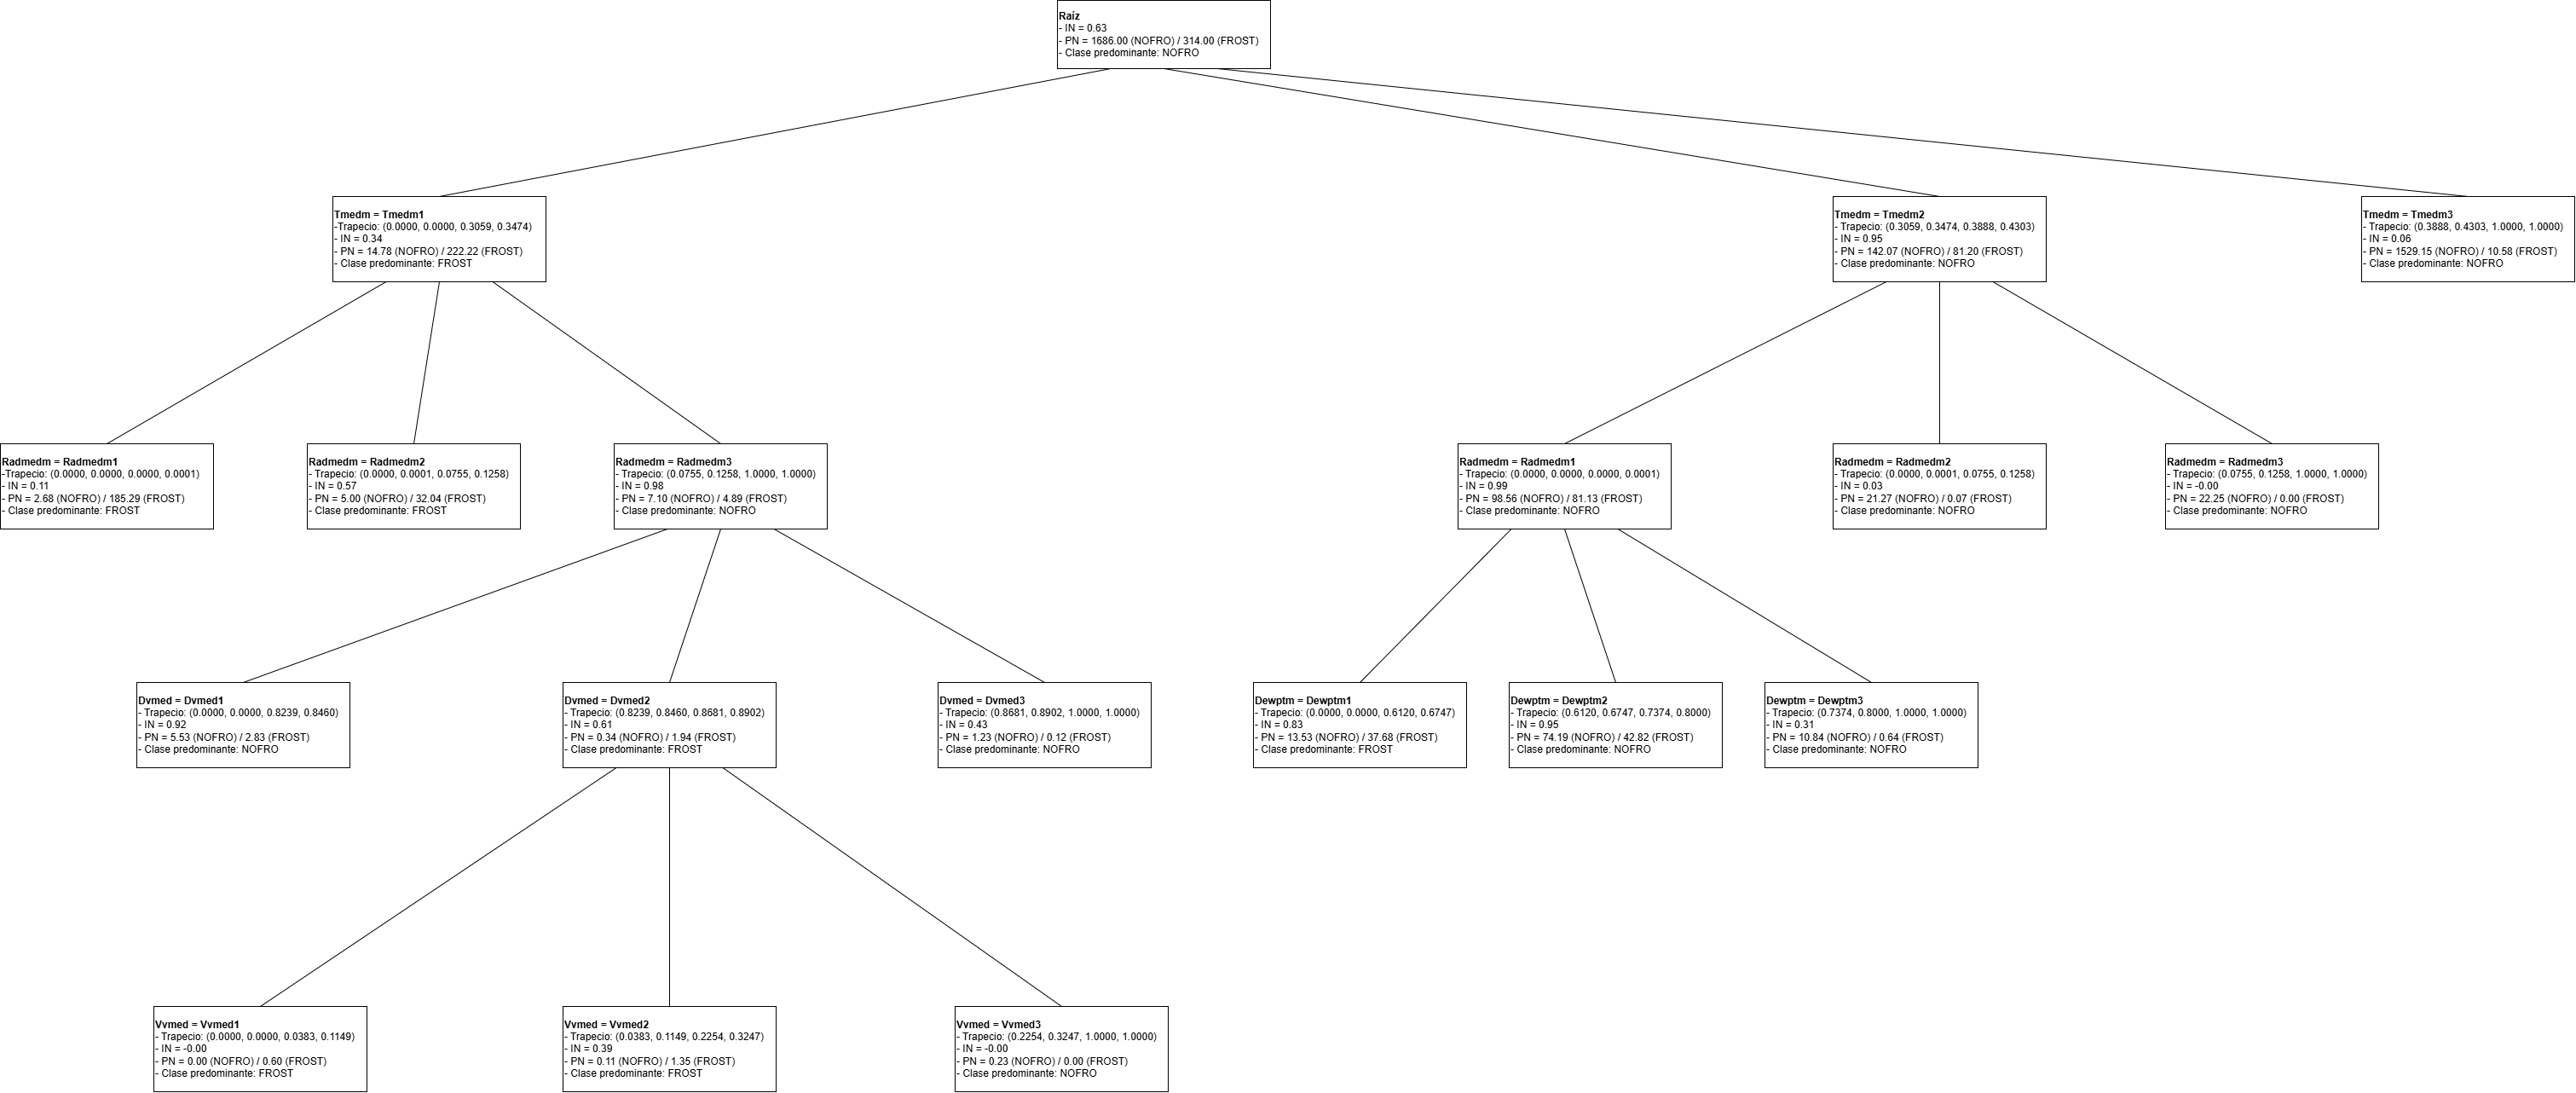

El número de ejemplos (PN) en los nodos toma valores decimales porque en un árbol de decisión difuso, un ejemplo puede pertenecer parcialmente a varios nodos debido a la naturaleza difusa de los atributos, ya que estos están compuestos por varios conjuntos difusos a los que se les asocia una función de pertenencia.

Por ejemplo, si $A_i$ es un atributo difuso (como los que tenemos en este árbol), entonces disponemos de una función de pertenencia para cada conjunto de la partición, $\mu_{A_i = V_{ik}}$ para el conjunto difuso $k$. De esta forma, dado un ejemplo $e^j$, este pertenecerá a uno o dos elementos de la partición con valores $\mu_{A_i = V_{ik}}(e^j)$. Más específicamente, pertenecerá a uno si $\mu_{A_i = V_{ik}}(e^j) = 1$ y a dos si $\mu_{A_i = V_{ik}}(e^j) < 1$.

De esta forma, el peso de un ejemplo $e^j$ en un nodo $Nod$ se calculará como $\chi_{Nod}(e^j) = \chi_{Nod-padre}(e^j) \cdot \mu_{A_i = V_{ik}}(e^j)$, y entonces calcularemos $|Nod|$ como la suma de los pesos de los ejemplos que contiene dicho nodo, $|Nod| = \sum_{e^j\in Nod}\chi_{Nod}(e^j)$. Es decir, que en lugar de contar el número de ejemplos de forma entera, como en un árbol tradicional, en este caso se suman los pesos de los ejemplos en cada nodo, dando como resultado valores decimales para el número total de ejemplos en un nodo, dado que un ejemplo puede contribuir parcialmente a varios nodos según su grado de pertenencia.

d) Realizar a mano las siguientes inferencias indicando las reglas activadas y cómo se llega a la decisión si consideramos la clase mayoritaria de la rama de mayor activación:

Definimos los conjuntos difusos que componen los atributos que aparecen en el árbol de decisión, que necesitaremos para definir las reglas.

In [6]:
# Librerías necesarias
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl

In [7]:
# Definir el universo para la variable difusa Tmedm
universe_Tmedm = np.arange(0, 1, 0.001)
Tmedm = ctrl.Antecedent(universe_Tmedm, 'Tmedm')

# Asignar las funciones de pertenencia a los valores lingüísticos de Tmed
Tmedm['Tmedm1'] = fuzz.trapmf(universe_Tmedm, [0.0000, 0.0000, 0.3059, 0.3474])
Tmedm['Tmedm2'] = fuzz.trapmf(universe_Tmedm, [0.3059, 0.3474, 0.3888, 0.4303])
Tmedm['Tmedm3'] = fuzz.trapmf(universe_Tmedm, [0.3888, 0.4303, 1.0000, 1.0000])

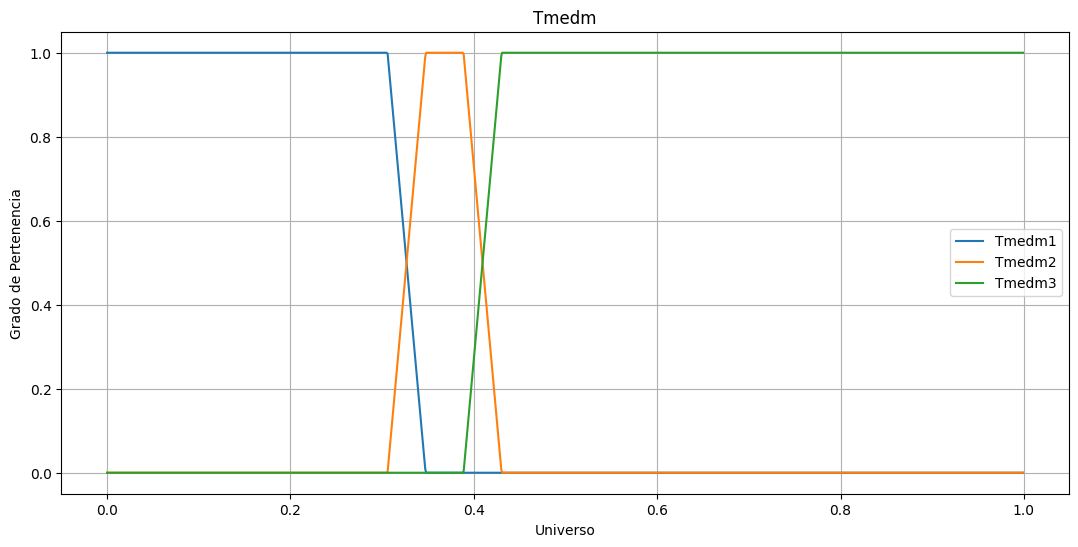

In [8]:
plt.figure(figsize=(13, 6))

# Graficar los conjuntos difusos
for label in Tmedm.terms:
    plt.plot(universe_Tmedm, Tmedm[label].mf, label=label)

# Etiquetas y título
plt.title('Tmedm')
plt.xlabel('Universo')
plt.ylabel('Grado de Pertenencia')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [9]:
# Definir el universo para la variable difusa Radmedm
universe_Radmedm = np.arange(0, 1, 0.001)
Radmedm = ctrl.Antecedent(universe_Radmedm, 'Radmedm')

# Asignar las funciones de pertenencia a los valores lingüísticos de Radmedm
Radmedm['Radmedm1'] = fuzz.trapmf(universe_Radmedm, [0.0000, 0.0000, 0.0000, 0.0001])
Radmedm['Radmedm2'] = fuzz.trapmf(universe_Radmedm, [0.0000, 0.0001, 0.0755, 0.1258])
Radmedm['Radmedm3'] = fuzz.trapmf(universe_Radmedm, [0.0755, 0.1258, 1.0000, 1.0000])

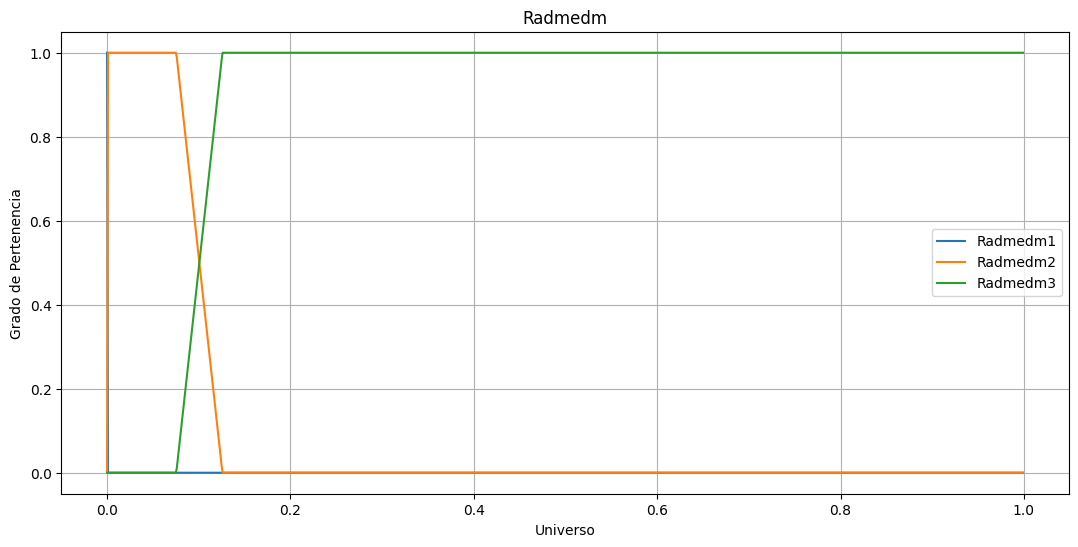

In [10]:
plt.figure(figsize=(13, 6))

# Graficar los conjuntos difusos
for label in Radmedm.terms:
    plt.plot(universe_Radmedm, Radmedm[label].mf, label=label)

# Etiquetas y título
plt.title('Radmedm')
plt.xlabel('Universo')
plt.ylabel('Grado de Pertenencia')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [11]:
# Definir el universo para la variable difusa Dvmed
universe_Dvmed = np.arange(0, 1, 0.001)
Dvmed = ctrl.Antecedent(universe_Dvmed, 'Dvmed')

# Asignar las funciones de pertenencia a los valores lingüísticos de Dvmed
Dvmed['Dvmed1'] = fuzz.trapmf(universe_Dvmed, [0.0000, 0.0000, 0.8239, 0.8460])
Dvmed['Dvmed2'] = fuzz.trapmf(universe_Dvmed, [0.8239, 0.8460, 0.8681, 0.8902])
Dvmed['Dvmed3'] = fuzz.trapmf(universe_Dvmed, [0.8681, 0.8902, 1.0000, 1.0000])

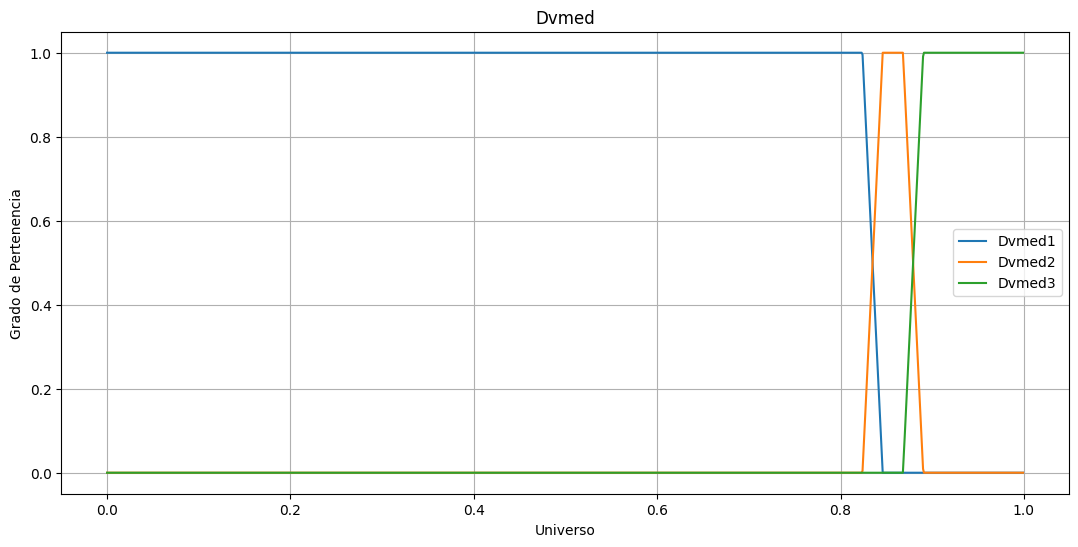

In [12]:
plt.figure(figsize=(13, 6))

# Graficar los conjuntos difusos
for label in Dvmed.terms:
    plt.plot(universe_Dvmed, Dvmed[label].mf, label=label)

# Etiquetas y título
plt.title('Dvmed')
plt.xlabel('Universo')
plt.ylabel('Grado de Pertenencia')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [13]:
# Definir el universo para la variable difusa Vvmed
universe_Vvmed = np.arange(0, 1, 0.001)
Vvmed = ctrl.Antecedent(universe_Vvmed, 'Vvmed')

# Asignar las funciones de pertenencia a los valores lingüísticos de Vvmed
Vvmed['Vvmed1'] = fuzz.trapmf(universe_Vvmed, [0.0000, 0.0000, 0.0383, 0.1149])
Vvmed['Vvmed2'] = fuzz.trapmf(universe_Vvmed, [0.0383, 0.1149, 0.2254, 0.3247])
Vvmed['Vvmed3'] = fuzz.trapmf(universe_Vvmed, [0.2254, 0.3247, 1.0000, 1.0000])

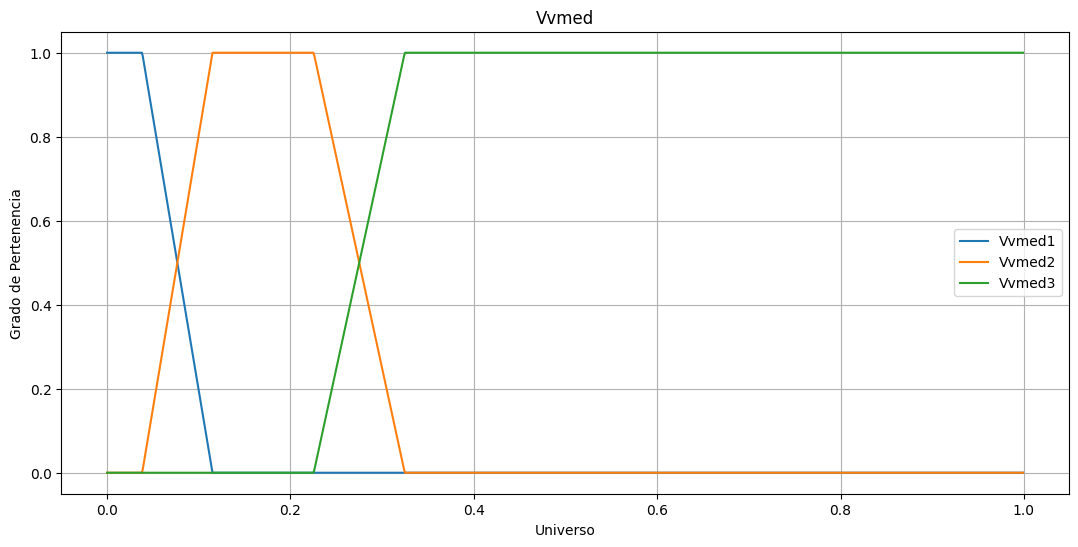

In [14]:
plt.figure(figsize=(13, 6))

# Graficar los conjuntos difusos
for label in Vvmed.terms:
    plt.plot(universe_Vvmed, Vvmed[label].mf, label=label)

# Etiquetas y título
plt.title('Vvmed')
plt.xlabel('Universo')
plt.ylabel('Grado de Pertenencia')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [15]:
# Definir el universo para la variable difusa Dewptm
universe_Dewptm = np.arange(0, 1, 0.001)
Dewptm = ctrl.Antecedent(universe_Dewptm, 'Dewptm')

# Asignar las funciones de pertenencia a los valores lingüísticos de Dewptm
Dewptm['Dewptm1'] = fuzz.trapmf(universe_Dewptm, [0.0000, 0.0000, 0.0383, 0.1149])
Dewptm['Dewptm2'] = fuzz.trapmf(universe_Dewptm, [0.0383, 0.1149, 0.2254, 0.3247])
Dewptm['Dewptm3'] = fuzz.trapmf(universe_Dewptm, [0.2254, 0.3247, 1.0000, 1.0000])

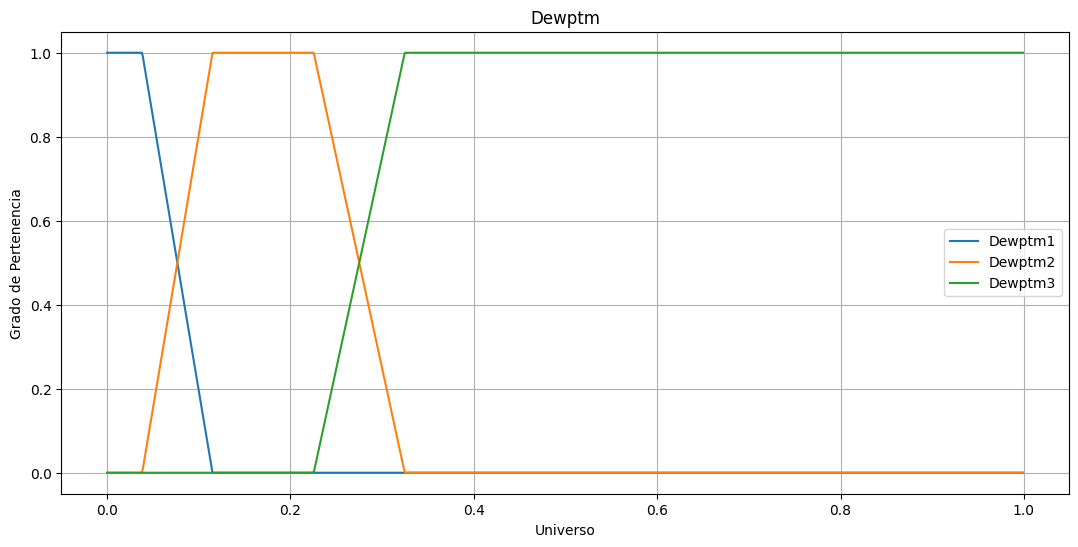

In [16]:
plt.figure(figsize=(13, 6))

# Graficar los conjuntos difusos
for label in Dewptm.terms:
    plt.plot(universe_Dewptm, Dewptm[label].mf, label=label)

# Etiquetas y título
plt.title('Dewptm')
plt.xlabel('Universo')
plt.ylabel('Grado de Pertenencia')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

Denotamos por "H" al atributo "heladas". Calculamos los valores de pertenencia a cada clase como:

$F_{R_i, H = FROST} = \frac{FROST}{PN}$

$F_{R_i, H = NOFRO} = \frac{NOFRO}{PN}$

Según el árbol, se obtienen $13$ reglas:

$R_1$: Si $Tmedm = Tmedm1$ y $Radmedm = Radmedm1$ entonces "H" es $\{FROST/0.9857424057030377, NOFRO/0.014257594296962281\}$

In [17]:
FROST = 185.29
NOFRO = 2.68
PN = 187.97

F_R1_FROST = FROST/PN
F_R1_NOFRO = NOFRO/PN

print('F_R1_FROST =', F_R1_FROST)
print('F_R1_NOFRO =', F_R1_NOFRO)

F_R1_FROST = 0.9857424057030377
F_R1_NOFRO = 0.014257594296962281


$R_2$: Si $Tmedm = Tmedm1$ y $Radmedm = Radmedm2$ entonces "H" es $\{FROST/0.8650107991360692, NOFRO/0.13498920086393087\}$

In [18]:
FROST = 32.04
NOFRO = 5.00
PN = 37.04

F_R2_FROST = FROST/PN
F_R2_NOFRO = NOFRO/PN

print('F_R2_FROST =', F_R2_FROST)
print('F_R2_NOFRO =', F_R2_NOFRO)

F_R2_FROST = 0.8650107991360692
F_R2_NOFRO = 0.13498920086393087


$R_3$: Si $Tmedm = Tmedm1$ y $Radmedm = Radmedm3$ y $Dvmed = Dvmed1$ entonces "H" es $\{FROST/0.33851674641148327, NOFRO/0.6614832535885168\}$

In [19]:
FROST = 2.83
NOFRO = 5.53
PN = 8.36

F_R3_FROST = FROST/PN
F_R3_NOFRO = NOFRO/PN

print('F_R3_FROST =', F_R3_FROST)
print('F_R3_NOFRO =', F_R3_NOFRO)

F_R3_FROST = 0.33851674641148327
F_R3_NOFRO = 0.6614832535885168


$R_4$: Si $Tmedm = Tmedm1$ y $Radmedm = Radmedm3$ y $Dvmed = Dvmed2$ y $Vvmed = Vvmed1$ entonces "H" es $\{FROST/1.0, NOFRO/0.0\}$

In [20]:
FROST = 0.60
NOFRO = 0.00
PN = 0.60

F_R4_FROST = FROST/PN
F_R4_NOFRO = NOFRO/PN

print('F_R4_FROST =', F_R4_FROST)
print('F_R4_NOFRO =', F_R4_NOFRO)

F_R4_FROST = 1.0
F_R4_NOFRO = 0.0


$R_5$: Si $Tmedm = Tmedm1$ y $Radmedm = Radmedm3$ y $Dvmed = Dvmed2$ y $Vvmed = Vvmed2$ entonces "H" es $\{FROST/0.9246575342465754, NOFRO/0.07534246575342465\}$

In [21]:
FROST = 1.35
NOFRO = 0.11
PN = 1.46

F_R5_FROST = FROST/PN
F_R5_NOFRO = NOFRO/PN

print('F_R5_FROST =', F_R5_FROST)
print('F_R5_NOFRO =', F_R5_NOFRO)

F_R5_FROST = 0.9246575342465754
F_R5_NOFRO = 0.07534246575342465


$R_6$: Si $Tmedm = Tmedm1$ y $Radmedm = Radmedm3$ y $Dvmed = Dvmed2$ y $Vvmed = Vvmed3$ entonces "H" es $\{FROST/0.0, NOFRO/1.0\}$

In [22]:
FROST = 0.00
NOFRO = 0.23
PN = 0.23

F_R6_FROST = FROST/PN
F_R6_NOFRO = NOFRO/PN

print('F_R6_FROST =', F_R6_FROST)
print('F_R6_NOFRO =', F_R6_NOFRO)

F_R6_FROST = 0.0
F_R6_NOFRO = 1.0


$R_7$: Si $Tmedm = Tmedm1$ y $Radmedm = Radmedm3$ y $Dvmed = Dvmed3$ entonces "H" es $\{FROST/0.08888888888888888, NOFRO/0.911111111111111\}$

In [23]:
FROST = 0.12
NOFRO = 1.23
PN = 1.35

F_R7_FROST = FROST/PN
F_R7_NOFRO = NOFRO/PN

print('F_R7_FROST =', F_R7_FROST)
print('F_R7_NOFRO =', F_R7_NOFRO)

F_R7_FROST = 0.08888888888888888
F_R7_NOFRO = 0.911111111111111


$R_8$: Si $Tmedm = Tmedm2$ y $Radmedm = Radmedm1$ y $Dewptm = Dewptm1$ entonces "H" es $\{FROST/0.7357937902753369, NOFRO/0.26420620972466313\}$

In [24]:
FROST = 37.68
NOFRO = 13.53
PN = 51.21

F_R8_FROST = FROST/PN
F_R8_NOFRO = NOFRO/PN

print('F_R8_FROST =', F_R8_FROST)
print('F_R8_NOFRO =', F_R8_NOFRO)

F_R8_FROST = 0.7357937902753369
F_R8_NOFRO = 0.26420620972466313


$R_9$: Si $Tmedm = Tmedm2$ y $Radmedm = Radmedm1$ y $Dewptm = Dewptm2$ entonces "H" es $\{FROST/0.36595162806597725, NOFRO/0.6340483719340226\}$

In [25]:
FROST = 42.82
NOFRO = 74.19
PN = 117.01

F_R9_FROST = FROST/PN
F_R9_NOFRO = NOFRO/PN

print('F_R9_FROST =', F_R9_FROST)
print('F_R9_NOFRO =', F_R9_NOFRO)

F_R9_FROST = 0.36595162806597725
F_R9_NOFRO = 0.6340483719340226


$R_{10}$: Si $Tmedm = Tmedm2$ y $Radmedm = Radmedm1$ y $Dewptm = Dewptm3$ entonces "H" es $\{FROST/0.05579773321708805, NOFRO/0.9450741063644289\}$

In [26]:
FROST = 0.64
NOFRO = 10.84
PN = 11.47

F_R10_FROST = FROST/PN
F_R10_NOFRO = NOFRO/PN

print('F_R10_FROST =', F_R10_FROST)
print('F_R10_NOFRO =', F_R10_NOFRO)

F_R10_FROST = 0.05579773321708805
F_R10_NOFRO = 0.9450741063644289


$R_{11}$: Si $Tmedm = Tmedm2$ y $Radmedm = Radmedm2$ entonces "H" es $\{FROST/0.0032817627754336623, NOFRO/0.9971870604781998\}$

In [27]:
FROST = 0.07
NOFRO = 21.27
PN = 21.33

F_R11_FROST = FROST/PN
F_R11_NOFRO = NOFRO/PN

print('F_R11_FROST =', F_R11_FROST)
print('F_R11_NOFRO =', F_R11_NOFRO)

F_R11_FROST = 0.0032817627754336623
F_R11_NOFRO = 0.9971870604781998


$R_{12}$: Si $Tmedm = Tmedm2$ y $Radmedm = Radmedm3$ entonces "H" es $\{FROST/0.0, NOFRO/1.0\}$

In [28]:
FROST = 0.00
NOFRO = 22.25
PN = 22.25

F_R12_FROST = FROST/PN
F_R12_NOFRO = NOFRO/PN

print('F_R12_FROST =', F_R12_FROST)
print('F_R12_NOFRO =', F_R12_NOFRO)

F_R12_FROST = 0.0
F_R12_NOFRO = 1.0


$R_{13}$: Si $Tmedm = Tmedm3$ entonces "H" es $\{FROST/0.006918876500016349, NOFRO/1.0\}$

In [29]:
FROST = 10.58
NOFRO = 1529.15
PN = 1529.15

F_R13_FROST = FROST/PN
F_R13_NOFRO = NOFRO/PN

print('F_R13_FROST =', F_R13_FROST)
print('F_R13_NOFRO =', F_R13_NOFRO)

F_R13_FROST = 0.006918876500016349
F_R13_NOFRO = 1.0


#### Caso 1

$e_1 = (-1, -1, -1, -1, 0.1263, 0.7881, -1, -1, -1, 0.5, -1, 0.0, -1, -1, -1, -1, 0.7649, -1, NOFRO, 1)$

- $Vvmed = 0.1263$
- $Dvmed = 0.7881$
- $Tmedm = 0.5$
- $Radmedm = 0.0$
- $Dewptm = 0.7649$

In [30]:
Vvmed_value = 0.1263
mu_Vvmed1 = fuzz.interp_membership(universe_Vvmed, Vvmed['Vvmed1'].mf, Vvmed_value)
mu_Vvmed2 = fuzz.interp_membership(universe_Vvmed, Vvmed['Vvmed2'].mf, Vvmed_value)
mu_Vvmed3 = fuzz.interp_membership(universe_Vvmed, Vvmed['Vvmed3'].mf, Vvmed_value)

print('mu_Vvmed1 =', mu_Vvmed1)
print('mu_Vvmed2 =', mu_Vvmed2)
print('mu_Vvmed3 =', mu_Vvmed3)

mu_Vvmed1 = 0.0
mu_Vvmed2 = 1.0
mu_Vvmed3 = 0.0


In [31]:
Dvmed_value = 0.7881
mu_Dvmed1 = fuzz.interp_membership(universe_Dvmed, Dvmed['Dvmed1'].mf, Dvmed_value)
mu_Dvmed2 = fuzz.interp_membership(universe_Dvmed, Dvmed['Dvmed2'].mf, Dvmed_value)
mu_Dvmed3 = fuzz.interp_membership(universe_Dvmed, Dvmed['Dvmed3'].mf, Dvmed_value)

print('mu_Dvmed1 =', mu_Dvmed1)
print('mu_Dvmed2 =', mu_Dvmed2)
print('mu_Dvmed3 =', mu_Dvmed3)

mu_Dvmed1 = 1.0
mu_Dvmed2 = 0.0
mu_Dvmed3 = 0.0


In [32]:
Tmedm_value = 0.5
mu_Tmedm1 = fuzz.interp_membership(universe_Tmedm, Tmedm['Tmedm1'].mf, Tmedm_value)
mu_Tmedm2 = fuzz.interp_membership(universe_Tmedm, Tmedm['Tmedm2'].mf, Tmedm_value)
mu_Tmedm3 = fuzz.interp_membership(universe_Tmedm, Tmedm['Tmedm3'].mf, Tmedm_value)

print('mu_Tmedm1 =', mu_Tmedm1)
print('mu_Tmedm2 =', mu_Tmedm2)
print('mu_Tmedm3 =', mu_Tmedm3)

mu_Tmedm1 = 0.0
mu_Tmedm2 = 0.0
mu_Tmedm3 = 1.0


In [33]:
Radmedm_value = 0.0
mu_Radmedm1 = fuzz.interp_membership(universe_Radmedm, Radmedm['Radmedm1'].mf, Radmedm_value)
mu_Radmedm2 = fuzz.interp_membership(universe_Radmedm, Radmedm['Radmedm2'].mf, Radmedm_value)
mu_Radmedm3 = fuzz.interp_membership(universe_Radmedm, Radmedm['Radmedm3'].mf, Radmedm_value)

print('mu_Radmedm1 =', mu_Radmedm1)
print('mu_Radmedm2 =', mu_Radmedm2)
print('mu_Radmedm3 =', mu_Radmedm3)

mu_Radmedm1 = 1.0
mu_Radmedm2 = 0.0
mu_Radmedm3 = 0.0


In [34]:
Dewptm_value = 0.7649
mu_Dewptm1 = fuzz.interp_membership(universe_Dewptm, Dewptm['Dewptm1'].mf, Dewptm_value)
mu_Dewptm2 = fuzz.interp_membership(universe_Dewptm, Dewptm['Dewptm2'].mf, Dewptm_value)
mu_Dewptm3 = fuzz.interp_membership(universe_Dewptm, Dewptm['Dewptm3'].mf, Dewptm_value)

print('mu_Dewptm1 =', mu_Dewptm1)
print('mu_Dewptm2 =', mu_Dewptm2)
print('mu_Dewptm3 =', mu_Dewptm3)

mu_Dewptm1 = 0.0
mu_Dewptm2 = 0.0
mu_Dewptm3 = 1.0


Los valores del ejemplo $e_1$ activan la regla $R_{13}$:

- Los antecendentes de la regla $R_{13}$ se activan con $\mu_{Tmedm3} = 1.0$. Entonces, $e_1$ activa la regla $R_{13}$ con valor:

    $\mu_{R_{13}, H = FROST} = \mu_{Tmedm3}\cdot F_{R_{13}, H = FROST} = 0.006918876500016349$

    $\mu_{R_{13}, H = NOFRO} = \mu_{Tmedm3}\cdot F_{R_{13}, H = NOFRO} = 1.0$

In [35]:
mu_R13_FROST = mu_Tmedm3*F_R13_FROST
mu_R13_NOFRO = mu_Tmedm3*F_R13_NOFRO

print('mu_R13_FROST =', mu_R13_FROST)
print('mu_R13_NOFRO =', mu_R13_NOFRO)

mu_R13_FROST = 0.006918876500016349
mu_R13_NOFRO = 1.0


Por tanto, el sistema difuso obtiene:

$\mu_{H = FROST} = \mu_{R_{13}, H = FROST} = 0.006918876500016349$

$\mu_{H = NOFRO} = \mu_{R_{13}, H = NOFRO} = 1.0$

La clase predicha es entonces NOFRO.

#### Caso 2

$e_2 = (-1, -1, -1, -1, 0.1263, 0.7881, -1, -1, -1, 0.2, -1, 0.0009, -1, -1, -1, -1, 0.7649, -1, FROST, 1)$

- $Vvmed = 0.1263$
- $Dvmed = 0.7881$
- $Tmedm = 0.2$
- $Radmedm = 0.0009$
- $Dewptm = 0.7649$

In [36]:
Vvmed_value = 0.1263
mu_Vvmed1 = fuzz.interp_membership(universe_Vvmed, Vvmed['Vvmed1'].mf, Vvmed_value)
mu_Vvmed2 = fuzz.interp_membership(universe_Vvmed, Vvmed['Vvmed2'].mf, Vvmed_value)
mu_Vvmed3 = fuzz.interp_membership(universe_Vvmed, Vvmed['Vvmed3'].mf, Vvmed_value)

print('mu_Vvmed1 =', mu_Vvmed1)
print('mu_Vvmed2 =', mu_Vvmed2)
print('mu_Vvmed3 =', mu_Vvmed3)

mu_Vvmed1 = 0.0
mu_Vvmed2 = 1.0
mu_Vvmed3 = 0.0


In [37]:
Dvmed_value = 0.7881
mu_Dvmed1 = fuzz.interp_membership(universe_Dvmed, Dvmed['Dvmed1'].mf, Dvmed_value)
mu_Dvmed2 = fuzz.interp_membership(universe_Dvmed, Dvmed['Dvmed2'].mf, Dvmed_value)
mu_Dvmed3 = fuzz.interp_membership(universe_Dvmed, Dvmed['Dvmed3'].mf, Dvmed_value)

print('mu_Dvmed1 =', mu_Dvmed1)
print('mu_Dvmed2 =', mu_Dvmed2)
print('mu_Dvmed3 =', mu_Dvmed3)

mu_Dvmed1 = 1.0
mu_Dvmed2 = 0.0
mu_Dvmed3 = 0.0


In [38]:
Tmedm_value = 0.2
mu_Tmedm1 = fuzz.interp_membership(universe_Tmedm, Tmedm['Tmedm1'].mf, Tmedm_value)
mu_Tmedm2 = fuzz.interp_membership(universe_Tmedm, Tmedm['Tmedm2'].mf, Tmedm_value)
mu_Tmedm3 = fuzz.interp_membership(universe_Tmedm, Tmedm['Tmedm3'].mf, Tmedm_value)

print('mu_Tmedm1 =', mu_Tmedm1)
print('mu_Tmedm2 =', mu_Tmedm2)
print('mu_Tmedm3 =', mu_Tmedm3)

mu_Tmedm1 = 1.0
mu_Tmedm2 = 0.0
mu_Tmedm3 = 0.0


In [39]:
Radmedm_value = 0.0009
mu_Radmedm1 = fuzz.interp_membership(universe_Radmedm, Radmedm['Radmedm1'].mf, Radmedm_value)
mu_Radmedm2 = fuzz.interp_membership(universe_Radmedm, Radmedm['Radmedm2'].mf, Radmedm_value)
mu_Radmedm3 = fuzz.interp_membership(universe_Radmedm, Radmedm['Radmedm3'].mf, Radmedm_value)

print('mu_Radmedm1 =', mu_Radmedm1)
print('mu_Radmedm2 =', mu_Radmedm2)
print('mu_Radmedm3 =', mu_Radmedm3)

mu_Radmedm1 = 0.09999999999999998
mu_Radmedm2 = 0.9
mu_Radmedm3 = 0.0


In [40]:
Dewptm_value = 0.7649
mu_Dewptm1 = fuzz.interp_membership(universe_Dewptm, Dewptm['Dewptm1'].mf, Dewptm_value)
mu_Dewptm2 = fuzz.interp_membership(universe_Dewptm, Dewptm['Dewptm2'].mf, Dewptm_value)
mu_Dewptm3 = fuzz.interp_membership(universe_Dewptm, Dewptm['Dewptm3'].mf, Dewptm_value)

print('mu_Dewptm1 =', mu_Dewptm1)
print('mu_Dewptm2 =', mu_Dewptm2)
print('mu_Dewptm3 =', mu_Dewptm3)

mu_Dewptm1 = 0.0
mu_Dewptm2 = 0.0
mu_Dewptm3 = 1.0


Los valores del ejemplo $e_2$ activan las reglas $R_{1}$ y $R_{2}$:

- Los antecendentes de la regla $R_{1}$ se activan con $\mu_{Tmedm1} = 1.0$ y $\mu_{Radmedm1} = 0.09999999999999998$. Por tanto, los antecedentes de la regla $R_1$ se activan con $\mu_{Tmedm1,Radmedm1} = \mu_{Tmedm1} \cdot \mu_{Radmedm1} = 0.09999999999999998$. Entonces, $e_2$ activa la regla $R_{1}$ con valor:

    $\mu_{R_{1}, H = FROST} = \mu_{Tmedm1,Radmedm1}\cdot F_{R_{1}, H = FROST} = 0.09857424057030376$

    $\mu_{R_{1}, H = NOFRO} = \mu_{Tmedm1,Radmedm1}\cdot F_{R_{1}, H = NOFRO} = 0.0014257594296962278$

In [41]:
mu_Tmedm1_Radmedm1 = mu_Tmedm1*mu_Radmedm1

print('mu_Tmedm1_Radmedm1 =', mu_Tmedm1_Radmedm1)

mu_Tmedm1_Radmedm1 = 0.09999999999999998


In [42]:
mu_R1_FROST = mu_Tmedm1_Radmedm1*F_R1_FROST
mu_R1_NOFRO = mu_Tmedm1_Radmedm1*F_R1_NOFRO

print('mu_R1_FROST =', mu_R1_FROST)
print('mu_R1_NOFRO =', mu_R1_NOFRO)

mu_R1_FROST = 0.09857424057030376
mu_R1_NOFRO = 0.0014257594296962278


- Los antecendentes de la regla $R_{2}$ se activan con $\mu_{Tmedm1} = 1.0$ y $\mu_{Radmedm2} = 0.9$. Por tanto, los antecedentes de la regla $R_2$ se activan con $\mu_{Tmedm1,Radmedm2} = \mu_{Tmedm1} \cdot \mu_{Radmedm2} = 0.9$. Entonces, $e_2$ activa la regla $R_{2}$ con valor:

    $\mu_{R_{2}, H = FROST} = \mu_{Tmedm1,Radmedm2}\cdot F_{R_{2}, H = FROST} = 0.7785097192224623$

    $\mu_{R_{2}, H = NOFRO} = \mu_{Tmedm1,Radmedm2}\cdot F_{R_{2}, H = NOFRO} = 0.12149028077753779$

In [43]:
mu_Tmedm1_Radmedm2 = mu_Tmedm1*mu_Radmedm2

print('mu_Tmedm1_Radmedm2 =', mu_Tmedm1_Radmedm2)

mu_Tmedm1_Radmedm2 = 0.9


In [44]:
mu_R2_FROST = mu_Tmedm1_Radmedm2*F_R2_FROST
mu_R2_NOFRO = mu_Tmedm1_Radmedm2*F_R2_NOFRO

print('mu_R2_FROST =', mu_R2_FROST)
print('mu_R2_NOFRO =', mu_R2_NOFRO)

mu_R2_FROST = 0.7785097192224623
mu_R2_NOFRO = 0.12149028077753779


Por tanto, el sistema difuso obtiene:

$\mu_{H = FROST} = \mu_{R_{1}, H = FROST} + \mu_{R_{2}, H = FROST} = 0.877083959792766$

$\mu_{H = NOFRO} = \mu_{R_{1}, H = NOFRO} + \mu_{R_{2}, H = FROST} = 0.12291604020723401$

La clase predicha es entonces FROST.

In [45]:
mu_FROST = mu_R1_FROST + mu_R2_FROST
mu_NOFRO = mu_R1_NOFRO + mu_R2_NOFRO

print('mu_FROST =', mu_FROST)
print('mu_NOFRO =', mu_NOFRO)

mu_FROST = 0.877083959792766
mu_NOFRO = 0.12291604020723401


#### Caso 3

$e_3 = (-1, -1, -1, -1, 0.7, 0.7881, -1, -1, -1, 0.2, -1, 0.2, -1, -1, -1, -1, 0.7649, -1, NOFRO, 1)$

- $Vvmed = 0.7$
- $Dvmed = 0.7881$
- $Tmedm = 0.2$
- $Radmedm = 0.2$
- $Dewptm = 0.7649$

In [46]:
Vvmed_value = 0.7
mu_Vvmed1 = fuzz.interp_membership(universe_Vvmed, Vvmed['Vvmed1'].mf, Vvmed_value)
mu_Vvmed2 = fuzz.interp_membership(universe_Vvmed, Vvmed['Vvmed2'].mf, Vvmed_value)
mu_Vvmed3 = fuzz.interp_membership(universe_Vvmed, Vvmed['Vvmed3'].mf, Vvmed_value)

print('mu_Vvmed1 =', mu_Vvmed1)
print('mu_Vvmed2 =', mu_Vvmed2)
print('mu_Vvmed3 =', mu_Vvmed3)

mu_Vvmed1 = 0.0
mu_Vvmed2 = 0.0
mu_Vvmed3 = 1.0


In [47]:
Dvmed_value = 0.7881
mu_Dvmed1 = fuzz.interp_membership(universe_Dvmed, Dvmed['Dvmed1'].mf, Dvmed_value)
mu_Dvmed2 = fuzz.interp_membership(universe_Dvmed, Dvmed['Dvmed2'].mf, Dvmed_value)
mu_Dvmed3 = fuzz.interp_membership(universe_Dvmed, Dvmed['Dvmed3'].mf, Dvmed_value)

print('mu_Dvmed1 =', mu_Dvmed1)
print('mu_Dvmed2 =', mu_Dvmed2)
print('mu_Dvmed3 =', mu_Dvmed3)

mu_Dvmed1 = 1.0
mu_Dvmed2 = 0.0
mu_Dvmed3 = 0.0


In [48]:
Tmedm_value = 0.2
mu_Tmedm1 = fuzz.interp_membership(universe_Tmedm, Tmedm['Tmedm1'].mf, Tmedm_value)
mu_Tmedm2 = fuzz.interp_membership(universe_Tmedm, Tmedm['Tmedm2'].mf, Tmedm_value)
mu_Tmedm3 = fuzz.interp_membership(universe_Tmedm, Tmedm['Tmedm3'].mf, Tmedm_value)

print('mu_Tmedm1 =', mu_Tmedm1)
print('mu_Tmedm2 =', mu_Tmedm2)
print('mu_Tmedm3 =', mu_Tmedm3)

mu_Tmedm1 = 1.0
mu_Tmedm2 = 0.0
mu_Tmedm3 = 0.0


In [49]:
Radmedm_value = 0.2
mu_Radmedm1 = fuzz.interp_membership(universe_Radmedm, Radmedm['Radmedm1'].mf, Radmedm_value)
mu_Radmedm2 = fuzz.interp_membership(universe_Radmedm, Radmedm['Radmedm2'].mf, Radmedm_value)
mu_Radmedm3 = fuzz.interp_membership(universe_Radmedm, Radmedm['Radmedm3'].mf, Radmedm_value)

print('mu_Radmedm1 =', mu_Radmedm1)
print('mu_Radmedm2 =', mu_Radmedm2)
print('mu_Radmedm3 =', mu_Radmedm3)

mu_Radmedm1 = 0.0
mu_Radmedm2 = 0.0
mu_Radmedm3 = 1.0


In [50]:
Dewptm_value = 0.7649
mu_Dewptm1 = fuzz.interp_membership(universe_Dewptm, Dewptm['Dewptm1'].mf, Dewptm_value)
mu_Dewptm2 = fuzz.interp_membership(universe_Dewptm, Dewptm['Dewptm2'].mf, Dewptm_value)
mu_Dewptm3 = fuzz.interp_membership(universe_Dewptm, Dewptm['Dewptm3'].mf, Dewptm_value)

print('mu_Dewptm1 =', mu_Dewptm1)
print('mu_Dewptm2 =', mu_Dewptm2)
print('mu_Dewptm3 =', mu_Dewptm3)

mu_Dewptm1 = 0.0
mu_Dewptm2 = 0.0
mu_Dewptm3 = 1.0


Los valores del ejemplo $e_3$ activan la regla $R_{3}$:

- Los antecendentes de la regla $R_{3}$ se activan con $\mu_{Tmedm1} = 1.0$, $\mu_{Radmedm3} = 1.0$ y $\mu_{Dvmed1} = 1.0$. Por tanto, los antecedentes de la regla $R_3$ se activan con $\mu_{Tmedm1,Radmedm3,Dvmed1} = \mu_{Tmedm1} \cdot \mu_{Radmedm3} \cdot \mu_{Dvmed1} = 1.0$. Entonces, $e_3$ activa la regla $R_{3}$ con valor:

    $\mu_{R_{3}, H = FROST} = \mu_{Tmedm1,Radmedm3,Dvmed1}\cdot F_{R_{3}, H = FROST} = 0.33851674641148327$

    $\mu_{R_{3}, H = NOFRO} = \mu_{Tmedm1,Radmedm3,Dvmed1}\cdot F_{R_{3}, H = NOFRO} = 0.6614832535885168$

In [51]:
mu_Tmedm1_Radmedm3_Dvmed1 = mu_Tmedm1*mu_Radmedm3*mu_Dvmed1

print('mu_Tmedm1_Radmedm3_Dvmed1 =', mu_Tmedm1_Radmedm3_Dvmed1)

mu_Tmedm1_Radmedm3_Dvmed1 = 1.0


In [52]:
mu_R3_FROST = mu_Tmedm1_Radmedm3_Dvmed1*F_R3_FROST
mu_R3_NOFRO = mu_Tmedm1_Radmedm3_Dvmed1*F_R3_NOFRO

print('mu_R3_FROST =', mu_R3_FROST)
print('mu_R3_NOFRO =', mu_R3_NOFRO)

mu_R3_FROST = 0.33851674641148327
mu_R3_NOFRO = 0.6614832535885168


Por tanto, el sistema difuso obtiene:

$\mu_{H = FROST} = \mu_{R_{3}, H = FROST} = 0.33851674641148327$

$\mu_{H = NOFRO} = \mu_{R_{3}, H = NOFRO} = 0.6614832535885168$

La clase predicha es entonces NOFRO.

#### Caso 4

$e_3 = (-1, -1, -1, -1, 0.7, 0.7881, -1, -1, -1, 0.4, -1, 0, -1, -1, -1, -1, 0.5, -1, NOFRO, 1)$

- $Vvmed = 0.7$
- $Dvmed = 0.7881$
- $Tmedm = 0.4$
- $Radmedm = 0$
- $Dewptm = 0.5$

In [53]:
Vvmed_value = 0.7
mu_Vvmed1 = fuzz.interp_membership(universe_Vvmed, Vvmed['Vvmed1'].mf, Vvmed_value)
mu_Vvmed2 = fuzz.interp_membership(universe_Vvmed, Vvmed['Vvmed2'].mf, Vvmed_value)
mu_Vvmed3 = fuzz.interp_membership(universe_Vvmed, Vvmed['Vvmed3'].mf, Vvmed_value)

print('mu_Vvmed1 =', mu_Vvmed1)
print('mu_Vvmed2 =', mu_Vvmed2)
print('mu_Vvmed3 =', mu_Vvmed3)

mu_Vvmed1 = 0.0
mu_Vvmed2 = 0.0
mu_Vvmed3 = 1.0


In [54]:
Dvmed_value = 0.7881
mu_Dvmed1 = fuzz.interp_membership(universe_Dvmed, Dvmed['Dvmed1'].mf, Dvmed_value)
mu_Dvmed2 = fuzz.interp_membership(universe_Dvmed, Dvmed['Dvmed2'].mf, Dvmed_value)
mu_Dvmed3 = fuzz.interp_membership(universe_Dvmed, Dvmed['Dvmed3'].mf, Dvmed_value)

print('mu_Dvmed1 =', mu_Dvmed1)
print('mu_Dvmed2 =', mu_Dvmed2)
print('mu_Dvmed3 =', mu_Dvmed3)

mu_Dvmed1 = 1.0
mu_Dvmed2 = 0.0
mu_Dvmed3 = 0.0


In [55]:
Tmedm_value = 0.4
mu_Tmedm1 = fuzz.interp_membership(universe_Tmedm, Tmedm['Tmedm1'].mf, Tmedm_value)
mu_Tmedm2 = fuzz.interp_membership(universe_Tmedm, Tmedm['Tmedm2'].mf, Tmedm_value)
mu_Tmedm3 = fuzz.interp_membership(universe_Tmedm, Tmedm['Tmedm3'].mf, Tmedm_value)

print('mu_Tmedm1 =', mu_Tmedm1)
print('mu_Tmedm2 =', mu_Tmedm2)
print('mu_Tmedm3 =', mu_Tmedm3)

mu_Tmedm1 = 0.0
mu_Tmedm2 = 0.7301204819277101
mu_Tmedm3 = 0.26987951807228994


In [56]:
Radmedm_value = 0
mu_Radmedm1 = fuzz.interp_membership(universe_Radmedm, Radmedm['Radmedm1'].mf, Radmedm_value)
mu_Radmedm2 = fuzz.interp_membership(universe_Radmedm, Radmedm['Radmedm2'].mf, Radmedm_value)
mu_Radmedm3 = fuzz.interp_membership(universe_Radmedm, Radmedm['Radmedm3'].mf, Radmedm_value)

print('mu_Radmedm1 =', mu_Radmedm1)
print('mu_Radmedm2 =', mu_Radmedm2)
print('mu_Radmedm3 =', mu_Radmedm3)

mu_Radmedm1 = 1.0
mu_Radmedm2 = 0.0
mu_Radmedm3 = 0.0


In [57]:
Dewptm_value = 0.5
mu_Dewptm1 = fuzz.interp_membership(universe_Dewptm, Dewptm['Dewptm1'].mf, Dewptm_value)
mu_Dewptm2 = fuzz.interp_membership(universe_Dewptm, Dewptm['Dewptm2'].mf, Dewptm_value)
mu_Dewptm3 = fuzz.interp_membership(universe_Dewptm, Dewptm['Dewptm3'].mf, Dewptm_value)

print('mu_Dewptm1 =', mu_Dewptm1)
print('mu_Dewptm2 =', mu_Dewptm2)
print('mu_Dewptm3 =', mu_Dewptm3)

mu_Dewptm1 = 0.0
mu_Dewptm2 = 0.0
mu_Dewptm3 = 1.0


Los valores del ejemplo $e_4$ activan las reglas $R_{10}$ y $R_{13}$:

- Los antecendentes de la regla $R_{10}$ se activan con $\mu_{Tmedm2} = 0.7301204819277101$, $\mu_{Radmedm1} = 1.0$ y $\mu_{Dewptm3} = 1.0$. Por tanto, los antecedentes de la regla $R_{10}$ se activan con $\mu_{Tmedm2,Radmedm1,Dewptm3} = \mu_{Tmedm2} \cdot \mu_{Radmedm1} \cdot \mu_{Dewptm3} = 0.7301204819277101$. Entonces, $e_4$ activa la regla $R_{10}$ con valor:

    $\mu_{R_{10}, H = FROST} = \mu_{Tmedm2,Radmedm1,Dewptm3}\cdot F_{R_{10}, H = FROST} = 0.040739067866934126$

    $\mu_{R_{10}, H = NOFRO} = \mu_{Tmedm2,Radmedm1,Dewptm3}\cdot F_{R_{10}, H = NOFRO} = 0.6900179619961968$

In [58]:
mu_Tmedm2_Radmedm1_Dewptm3 = mu_Tmedm2*mu_Radmedm1*mu_Dewptm3

print('mu_Tmedm2_Radmedm1_Dewptm3 =', mu_Tmedm2_Radmedm1_Dewptm3)

mu_Tmedm2_Radmedm1_Dewptm3 = 0.7301204819277101


In [59]:
mu_R10_FROST = mu_Tmedm2_Radmedm1_Dewptm3*F_R10_FROST
mu_R10_NOFRO = mu_Tmedm2_Radmedm1_Dewptm3*F_R10_NOFRO

print('mu_R10_FROST =', mu_R10_FROST)
print('mu_R10_NOFRO =', mu_R10_NOFRO)

mu_R10_FROST = 0.040739067866934126
mu_R10_NOFRO = 0.6900179619961968


- Los antecendentes de la regla $R_{13}$ se activan con $\mu_{Tmedm3} = 0.26987951807228994$. Entonces, $e_4$ activa la regla $R_{13}$ con valor:

    $\mu_{R_{13}, H = FROST} = \mu_{Tmedm3}\cdot F_{R_{13}, H = FROST} = 0.0018672630554261043$

    $\mu_{R_{13}, H = NOFRO} = \mu_{Tmedm3}\cdot F_{R_{13}, H = NOFRO} = 0.26987951807228994$

In [60]:
mu_R13_FROST = mu_Tmedm3*F_R13_FROST
mu_R13_NOFRO = mu_Tmedm3*F_R13_NOFRO

print('mu_R13_FROST =', mu_R13_FROST)
print('mu_R13_NOFRO =', mu_R13_NOFRO)

mu_R13_FROST = 0.0018672630554261043
mu_R13_NOFRO = 0.26987951807228994


Por tanto, el sistema difuso obtiene:

$\mu_{H = FROST} = \mu_{R_{10}, H = FROST} + \mu_{R_{13}, H = FROST} = 0.04260633092236023$

$\mu_{H = NOFRO} = \mu_{R_{10}, H = NOFRO} + \mu_{R_{13}, H = FROST} = 0.9598974800684867$

La clase predicha es entonces NOFRO.

In [61]:
mu_FROST = mu_R10_FROST + mu_R13_FROST
mu_NOFRO = mu_R10_NOFRO + mu_R13_NOFRO

print('mu_FROST =', mu_FROST)
print('mu_NOFRO =', mu_NOFRO)

mu_FROST = 0.04260633092236023
mu_NOFRO = 0.9598974800684867


e) Comprueba las decisiones tomadas en d) con las llevadas a cabo por el software FID3.5 (para ello, ejecútalo con el fichero test compuesto con las 4 instancias e indicando que realice la inferencia con la clase mayoritaria (internal = best) de la rama de mayor activación (external=2)).